In [1]:
from collections import Counter
import numpy as np
import Constants
# from DataManager import DataError, DataManager
# from Experiment import Experiment

In [2]:
RECALL_TSV = '../data/recall_oriented.tsv'
PRECISION_TSV = '../data/precision_oriented.tsv'
UNIFORM_TSV = '../data/uniformly_sampled.tsv'

RECALL_DATA = '../data/hydrated_recall.json'
PRECISION_DATA = '../data/hydrated_precision.json'
UNIFORM_DATA = '../data/hydrated_uniform.json'

LANG_CODES = '../data/lang_codes.txt'

In [11]:
class DataError(Exception):
    def __init__(self, message):
        self.message = message


class DataManager(object):

    def __init__(self,
                 annotated_tsv=Constants.RECALL_TSV,
                 retrieved_data=Constants.RECALL_DATA,
                 lang_codes_file=Constants.LANG_CODES):
        self.initialized = False
        self.annotated_tsv = annotated_tsv
        self.retrieved_data = retrieved_data
        self.lang_codes_file = lang_codes_file

    def initialize(self, splits=(0.60, 0.20, 0.20), shuffle=True):
        if self.initialized:
            return
        self.lang_codes = self._load_lang_codes()
        self.tweet_labels, self.canonical_inv_idx = \
            self._load_tweet_labels()
        self.tweet_text, self.hydrated_inv_idx = self._load_tweet_text()
        self._split_dataset(splits, shuffle)
        self.initialized = True

    def _split_dataset(self, splits, shuffle):
        if type(splits) not in [list, tuple] or len(splits) != 3:
            err_msg = 'splits should be collection (list or tuple) of length 3'
            raise DataError(err_msg)
        if sum(splits) != 1.0:
            raise DataError('split percentages should sum to 1.0')

        # percentage_split() code source: http://bit.ly/2buzsDm
        def percentage_split(seq, percentages):
            if shuffle:
                np.random.shuffle(seq)
            cdf = np.cumsum(percentages)
            stops = map(int, cdf * len(seq))
            return [seq[a:b] for a, b in zip([0] + stops, stops)]

        self.X_train, self.y_train = [], []
        self.X_dev, self.y_dev = [], []
        self.X_test, self.y_test = [], []
        for lang in self.hydrated_inv_idx:
            if lang not in self.lang_codes:
                continue
            tweet_ids = list(self.hydrated_inv_idx[lang])
            train, dev, test = percentage_split(tweet_ids, splits)
            self.X_train += [self.tweet_text[t] for t in train]
            self.y_train += [lang] * len(train)
            self.X_dev += [self.tweet_text[t] for t in dev]
            self.y_dev += [lang] * len(dev)
            self.X_test += [self.tweet_text[t] for t in test]
            self.y_test += [lang] * len(test)

    def _load_lang_codes(self):
        lang_codes = set()
        with open(self.lang_codes_file) as fp:
            for line in fp:
                lang_codes.add(line.strip())
        return lang_codes

    def _update_inverted_index(self, inv_idx, lang, tweet_id):
        if lang in inv_idx:
            inv_idx[lang].add(tweet_id)
        else:
            inv_idx[lang] = set([tweet_id])
        return inv_idx

    def _load_tweet_labels(self):
        D = {}
        inv_idx = {}
        with open(self.annotated_tsv) as tsv:
            for line in tsv:
                t_lang, t_id = line.strip().split('\t')
                D[t_id] = t_lang
                self._update_inverted_index(inv_idx, t_lang, t_id)
        return D, inv_idx

    def _load_tweet_text(self):
        D = {}
        inv_idx = {}
        with open(self.retrieved_data) as fp:
            for line in fp:
                stripped = line.strip()[2:-2]  # remove quotes and brackets
                t_id, t_text = stripped.split('\",\"')
                D[t_id] = t_text
                self._update_inverted_index(inv_idx,
                                            self.tweet_labels[t_id],
                                            t_id)
        return D, inv_idx

    def training_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_train[:], self.y_train[:]

    def dev_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_dev[:], self.y_dev[:]

    def test_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_test[:], self.y_test[:]

    def hydrated_diff(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        for lang in self.lang_codes:
            try:
                diff = (len(self.canonical_inv_idx[lang]) -
                        len(self.hydrated_inv_idx[lang]))
            except KeyError:
                diff = None
            print('{}: {}'.format(lang, diff))


In [4]:
import numpy as np
import sklearn.linear_model
from sklearn.feature_extraction.text import TfidfVectorizer


class Experiment(object):
    '''
    Organize the process of getting data, building a classifier,
    and exploring new representations. Modified from and credit to:
    Matthew Stone, CS 533, Spring 2017 - Classifier Patterns
    '''

    def __init__(self,
                 data_manager,
                 classifier,
                 cleaning_operations,
                 filtering_operations,
                 vectorizer,
                 shuffle=False,
                 seed=None):
        # TODO: Change name/defaults of some of these parameters
        '''set up the problem of learning a classifier from a data manager'''
        self.data_manager = data_manager
        self.classifier = classifier
        self.cleaning_operations = cleaning_operations
        self.filtering_operations = filtering_operations
        self.vectorizer = vectorizer
        self.shuffle = shuffle
        self.seed = seed
        self.initialized = False

    def initialize(self):
        '''materialize the training data, dev data and test data as matrices'''
        if self.initialized:
            return
        self.X_train_text, self.y_train_text = \
            self.data_manager.training_data()
        self.X_dev_text, self.y_dev_text = \
            self.data_manager.dev_data()
        self.X_test_text, self.y_test_text = \
            self.data_manager.test_data()
        self._filter()
        self._clean()
        self._extract_features()
        if self.shuffle:
            self._shuffle()
        self.initialized = True

    def _clean(self):
        '''
        The order of the list of operations matters! It is recommended to have
            'replace_newline_char' be the first in cleaning_operations.
            Cleaning will not remove data!
        '''
        for op in self.cleaning_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            f(self.X_train_text, self.y_train_text, **args)
            f(self.X_dev_text, self.y_dev_text, **args)
            f(self.X_test_text, self.y_test_text, **args)


    def _filter(self):
        '''
        The order of the list of operations matters! Filtering will remove data!
        '''
        for op in self.filtering_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            self.X_train_text, self.y_train_text = \
                f(self.X_train_text, self.y_train_text, **args)
            self.X_dev_text, self.y_dev_text = \
                f(self.X_dev_text, self.y_dev_text, **args)
            self.X_test_text, self.y_test_text = \
                f(self.X_test_text, self.y_test_text, **args)
                
                
    def _extract_features(self):
        '''
        Vectorizer should return NxM matrix where N is number of samples and
            M is number of features (dimension)
        '''
        self.X_train = self.vectorizer.fit_transform(self.X_train_text)
        self.X_dev = self.vectorizer.transform(self.X_dev_text)
        self.X_test = self.vectorizer.transform(self.X_test_text)

        # TODO: Ensure no zero vectors or any funny business
        # TODO: convert labels to integers and maintain a mapping
        S = list(set(self.y_train_text + self.y_dev_text + self.y_test_text))
        self.lang_to_num = dict(zip(S, range(len(S))))
        self.num_to_lang = {v: k for k, v in self.lang_to_num.iteritems()}

        conv = lambda x: self.lang_to_num[x]
        self.y_train = map(conv, self.y_train_text)
        self.y_dev = map(conv, self.y_dev_text)
        self.y_test = map(conv, self.y_test_text)

    def _shuffle(self):
        if self.seed:
            np.random.seed(self.seed)
        p = np.random.permutation(len(self.y_train))
        self.X_train = self.X_train[p]
        self.X_train_text = [self.X_train_text[i] for i in p]
        self.y_train = [self.y_train[i] for i in p]
        self.y_train_text = [self.y_train_text[i] for i in p]

    
    def fit_and_validate(self):
        '''train the classifier and assess predictions on dev data'''
        if not self.initialized:
            self.initialize()
        self.classifier.fit(self.X_train, self.y_train)
        self.dev_predictions = self.classifier.predict(self.X_dev)
        self.dev_accuracy = \
            sklearn.metrics.accuracy_score(self.y_dev, self.dev_predictions)

    '''
    @classmethod
    def transform(cls, expt, operation, classifier):
        'use operations to transform the data and set up new expt'
        if not expt.initialized:
            expt.initialize()
        result = cls(expt.data, classifier)
        result.X_train, result.y_train = operation(expt.X_train, expt.y_train)
        result.X_dev, result.y_dev = operation(expt.X_dev, expt.y_dev)
        result.X_test, result.y_test = operation(expt.X_test, expt.y_test)
        result.initialized = True
        return result
    '''


In [5]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [154]:
import re
import string


def decode_unicode(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.decode('utf-8')
    return X, y


def remove_newline_char(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace(r'\n', ' ')
    return X, y


def remove_RT(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace('RT', '')
    return X, y


def remove_urls(X, y):
    pattern = 'http\S+'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_handles(X, y):
    pattern = '@[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_hashtags(X, y):
    pattern = '#[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_punctutation(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.translate(None, string.punctuation)
    return X, y


def remove_emojis(X, y, emojis):
    for idx, x in enumerate(X):
        for emoji in emojis:
            x = x.replace(emoji, '')
        X[idx] = x
    return X, y


In [155]:
dm = DataManager(RECALL_TSV, RECALL_DATA, LANG_CODES)
dm.initialize(shuffle=True)

In [156]:
import cPickle as pickle
with open('../data/emoji_unicode.pkl', 'rb') as f:
    emojis = pickle.load(f)

In [178]:
import time

# langs_to_use = ['es', 'fr', 'en', 'de', 'uk', 'ru']
# langs_to_use = ['sr', 'bs', 'hr']
# langs_to_use = ['zh-CN', 'zh-TW', 'vi']
langs_to_use = ['en', 'zh-CN']

X, y = dm.training_data()

def filt_by_lang(X, y, langs_to_use):
    indices = []
    for idx, lang in enumerate(y):
        if lang in langs_to_use:
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

t0 = time.time()
X1, y1 = zip(*filter(lambda pair: pair[1] in langs_to_use, zip(X, y)))
print('time elapsed: {}'.format(time.time() - t0))

t0 = time.time()
X2, y2 = filt_by_lang(X, y, langs_to_use)
print('time elapsed: {}'.format(time.time() - t0))

print len(X1), len(y1)
print len(X2), len(y2)

time elapsed: 0.0237619876862
time elapsed: 0.00576901435852
966 966
966 966


In [179]:
identity = lambda x: np.array(x)
# vectorizer = TfidfVectorizer(sublinear_tf=True,
#                              smooth_idf=True,
#                              ngram_range=(1, 2),
#                              analyzer='word')
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             smooth_idf=True,
                             ngram_range=(1, 1),
                             analyzer='char')


classifier = \
sklearn.linear_model.SGDClassifier(loss="log",
                                   penalty="elasticnet",
                                   n_iter=5)

# classifier = \
#     sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

# classifier = \
#     sklearn.

clean_ops = [
    decode_unicode, remove_newline_char, remove_RT, remove_urls,
    remove_handles, remove_hashtags, (remove_emojis, {'emojis': emojis})
]
filter_ops = [
    (filt_by_lang, {'langs_to_use': langs_to_use})
]
empty_ops = []
expt = Experiment(dm,
                  classifier=classifier,
                  cleaning_operations=clean_ops,
                  filtering_operations=filter_ops,
                  vectorizer=vectorizer,
                  shuffle=True)
expt.initialize()

In [175]:
fn = vectorizer.get_feature_names()
print len(fn)
# print fn
for k, v in vectorizer.vocabulary_.iteritems(): print k, v

121
в 79
љ 103
б 78
— 108
‘ 109
“ 111
п 91
  0
" 2
а 77
& 4
( 6
« 61
* 8
, 10
. 12
0 14
2 16
4 18
ж 83
ś 73
8 22
» 63
к 86
м 88
д 81
р 92
т 94
ф 96
″ 115
ш 100
6 20
● 118
ђ 101
и 85
ј 102
њ 104
˝ 76
\ 29
` 32
b 34
d 36
ç 64
f 38
h 40
j 42
í 66
l 44
n 46
p 48
r 50
t 52
v 54
x 56
z 58
| 59
ž 75
_ 31
ć 68
č 69
️ 120
đ 70
– 107
; 25
’ 110
1 15
5 19
” 112
ğ 71
! 1
 60
% 3
' 5
⁰ 116
) 7
: 24
+ 9
ц 98
- 11
€ 117
/ 13
ı 72
° 62
3 17
е 82
з 84
9 23
л 87
„ 113
н 89
? 27
с 93
у 95
х 97
ツ 119
ч 99
a 33
= 26
г 80
ћ 105
] 30
џ 106
š 74
c 35
e 37
g 39
i 41
è 65
k 43
… 114
m 45
o 47
7 21
q 49
s 51
[ 28
u 53
w 55
ö 67
y 57
о 90


In [180]:
expt.fit_and_validate()
print sklearn.metrics.accuracy_score(expt.y_dev, expt.dev_predictions)
print sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
print expt.num_to_lang

0.990683229814
[[121   2]
 [  1 198]]
{0: 'zh-CN', 1: 'en'}


Normalized confusion matrix
[[ 0.98373984  0.01626016]
 [ 0.00502513  0.99497487]]


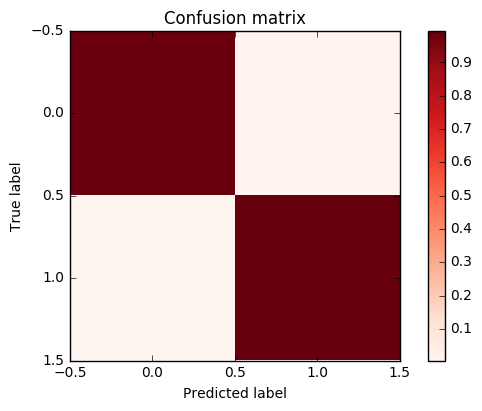

In [181]:
cm = sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm, [expt.num_to_lang[k] for k in xrange(2)], normalize=True)
plt.show()

In [100]:
diags = cm.diagonal()
thres = 0.10
under_peformed = [expt.num_to_lang[i] for i in np.where(diags < thres)[0]]
print('{} / {} underperformed (below {} accuracy)'.format(len(under_peformed), len(diags), thres))
print under_peformed

12 / 69 underperformed (below 0.1 accuracy)
['ug', 'am', 'eu', 'tr', 'lt', 'da', 'zh-CN', 'ja', 'sr', 'ko', 'uk', 'zh-TW']
